Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая будет предсказывать температуру стали конечную температуру после всех присыпок.

### План:
- загрузить данные и привести к нужным форматам
- провести исследовательский анализ
    - выявить особенности и различные факторы для обучения модели
    - выявить аномалии
    - проверить на адекватность
- Выводим таргет и факторы по которым будет обучаться и предсказывать модель
    - ТАРГЕТ: Вывести последнюю температуру по партиям и удалить партии, где после последнего замера были еще присыпки
    - Первая температура по партии
    - Активную температуру по партии
    - Длительность нагрева
    - Суммировать данные по сыпучим матерьялам по партиям
    - Суммировать данные по газам по партиям
    - Суммировать данные по проволочным матерьялам по партиям
    - Первая температура по партии
- Делим получившийся датафрейм на обучающую, валидационную и тестовую выборки
- Пробуем разные модели и подгоняем гиперпараметры. Оперделяем лучшую модель.
- Тестируем лучшую модель на тестовой выборке
- Пишем выводы

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np     
import datetime as dt
import seaborn as sns

from scipy import stats as st
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
!pip install lightgbm==3.2.1
import lightgbm as lgb
from lightgbm import LGBMRegressor
!pip install catboost
import catboost
from catboost import CatBoostRegressor, Pool, cv
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
!pip install shap
import shap


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.linear_model import LinearRegression
!pip install lightgbm==3.2.1
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer




     |████████████████████████████████| 2.0 MB 2.2 MB/s eta 0:00:01
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 3.3.1
    Uninstalling lightgbm-3.3.1:
      Successfully uninstalled lightgbm-3.3.1
     |████████████████████████████████| 572 kB 1.7 MB/s eta 0:00:01


Открываем датафреймы, сразу приводя индексы и даты к порядку

In [2]:
# file = '/Users/churk/1.Проекты/Выпускной/final_steel/'
file = '/datasets/final_steel/'  # СПАСИБО

data_arc = pd.read_csv(file + r"data_arc.csv", index_col=0, parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
data_bulk = pd.read_csv(file + r"data_bulk.csv", index_col=0)
data_bulk_time = pd.read_csv(file + r"data_bulk_time.csv", index_col=0)
data_bulk_time = pd.read_csv(file + r"data_bulk_time.csv", index_col=0, parse_dates=data_bulk_time.columns.tolist())
data_gas = pd.read_csv(file + r"data_gas.csv", index_col=0)
data_temp = pd.read_csv(file + r"data_temp.csv", index_col=0,  parse_dates=['Время замера'])
data_wire = pd.read_csv(file + r"data_wire.csv", index_col=0)
data_wire_time = pd.read_csv(file + r"data_wire_time.csv", index_col=0)
data_wire_time = pd.read_csv(file + r"data_wire_time.csv", index_col=0, parse_dates=data_wire_time.columns.tolist())
data_wire_time

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...
3237,2019-08-31 22:50:20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3238,2019-08-31 23:38:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3239,2019-09-01 01:50:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [3]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15907 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Время замера  15907 non-null  datetime64[ns]
 1   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 372.8 KB


# Исследовательский анализ
- Сейчас мы начнем по кусочкам формировать датафрейм по которому будет обучаться модель. Ну и будем проверять каждый кусочек на различные анамалии и общую адекватность.
- таргетом нашей будущей модели являеться температура последнего замера, которые указаны в датафрейме data_temp
Далее идут признаки на основании которых модель будет принимать решения и вообще обучаться
- Первая температура по партии
- Длительность обработки
- Активную мощьность по партии
- Суммировать данные по сыпучим матерьялам по партиям
- Суммировать данные по газам по партиям
- Суммировать данные по проволочным матерьялам по партиям

Находим последний замер и добавляем к нему температуру.

In [4]:
df = data_temp.pivot_table(index=['key'], values=['Время замера', 'Температура'], 
                           aggfunc={"Время замера": max, "Температура": 'last'})
df

,Время замера,Температура
key,,
1,2019-05-03 11:30:39,1613.0
2,2019-05-03 11:59:12,1602.0
3,2019-05-03 12:34:57,1599.0
4,2019-05-03 12:59:25,1625.0
5,2019-05-03 13:36:01,1602.0
...,...,...
3237,2019-08-31 23:05:43,1569.0
3238,2019-08-31 23:43:00,1584.0
3239,2019-09-01 02:24:15,1598.0


In [5]:
data_temp.head(30)

,Время замера,Температура
key,,
1,2019-05-03 11:16:18,1571.0
1,2019-05-03 11:25:53,1604.0
1,2019-05-03 11:29:11,1618.0
1,2019-05-03 11:30:01,1601.0
1,2019-05-03 11:30:39,1613.0
2,2019-05-03 11:37:27,1581.0
2,2019-05-03 11:38:00,1577.0
2,2019-05-03 11:49:38,1589.0
2,2019-05-03 11:55:50,1604.0


Проверяем на аномалии и адекватность

In [6]:
df.describe()

,Температура
count,3216.000000
mean,1593.928483
std,19.874627
min,1204.000000
25%,1585.000000
50%,1593.000000
75%,1600.000000
max,1700.000000


Разброс по температурам достаточно большой, но данные распределенны равномерно, так что аномалий нет.
Теперь найдем те замеры, после которых еще были присыпки

In [7]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Bulk 1   252 non-null    datetime64[ns]
 1   Bulk 2   22 non-null     datetime64[ns]
 2   Bulk 3   1298 non-null   datetime64[ns]
 3   Bulk 4   1014 non-null   datetime64[ns]
 4   Bulk 5   77 non-null     datetime64[ns]
 5   Bulk 6   576 non-null    datetime64[ns]
 6   Bulk 7   25 non-null     datetime64[ns]
 7   Bulk 8   1 non-null      datetime64[ns]
 8   Bulk 9   19 non-null     datetime64[ns]
 9   Bulk 10  176 non-null    datetime64[ns]
 10  Bulk 11  177 non-null    datetime64[ns]
 11  Bulk 12  2450 non-null   datetime64[ns]
 12  Bulk 13  18 non-null     datetime64[ns]
 13  Bulk 14  2806 non-null   datetime64[ns]
 14  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15)
memory usage: 391.1 KB


У нас достаточно много пропусков в последнем столбце, так что чтобы узнать время последней присыпки придется их заполнить. Метод apply в данном случае на 3000 строк весьма шустро справиться)

In [8]:
def final_bulk_past(stroka):
    stroka = stroka.dropna()
    return stroka[-1]

data_bulk_time['final_bulk'] = data_bulk_time.apply(final_bulk_past, axis=1)  
data_bulk_time.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,final_bulk
key,,,,,,,,,,,,,,,,
1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:03:52
2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:40:20
3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:09:40
4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:41:24
5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:12:56


проверяем как заполненны пропуски

In [9]:
data_bulk_time[data_bulk_time['Bulk 15'].isnull()].head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,final_bulk
key,,,,,,,,,,,,,,,,
19,NaT,NaT,NaT,NaT,NaT,2019-05-04 00:53:02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-04 00:53:02
20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-04 01:44:28,NaT,2019-05-04 01:44:28
22,NaT,NaT,2019-05-04 04:29:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-04 04:24:59,NaT,2019-05-04 04:24:59
26,NaT,NaT,2019-05-04 07:28:33,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-04 07:28:33
28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-04 08:30:00,NaT,2019-05-04 08:30:00,NaT,2019-05-04 08:30:00


In [10]:
data_bulk_time[data_bulk_time['final_bulk'].isnull()]

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,final_bulk
key,,,,,,,,,,,,,,,,


Пропуски заполненны как задуманно по последней присыпке и полностью.  
Убираем из таргета те строки, которые произошли раньше последней присыпки

In [11]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Bulk 1      252 non-null    datetime64[ns]
 1   Bulk 2      22 non-null     datetime64[ns]
 2   Bulk 3      1298 non-null   datetime64[ns]
 3   Bulk 4      1014 non-null   datetime64[ns]
 4   Bulk 5      77 non-null     datetime64[ns]
 5   Bulk 6      576 non-null    datetime64[ns]
 6   Bulk 7      25 non-null     datetime64[ns]
 7   Bulk 8      1 non-null      datetime64[ns]
 8   Bulk 9      19 non-null     datetime64[ns]
 9   Bulk 10     176 non-null    datetime64[ns]
 10  Bulk 11     177 non-null    datetime64[ns]
 11  Bulk 12     2450 non-null   datetime64[ns]
 12  Bulk 13     18 non-null     datetime64[ns]
 13  Bulk 14     2806 non-null   datetime64[ns]
 14  Bulk 15     2248 non-null   datetime64[ns]
 15  final_bulk  3129 non-null   datetime64[ns]
dtypes: datetime64[ns](16)
me

In [12]:
df = df[((df['Время замера'] - data_bulk_time['final_bulk']).dt.days >= 0)]
df

,Время замера,Температура
key,,
1,2019-05-03 11:30:39,1613.0
2,2019-05-03 11:59:12,1602.0
3,2019-05-03 12:34:57,1599.0
4,2019-05-03 12:59:25,1625.0
5,2019-05-03 13:36:01,1602.0
...,...,...
3237,2019-08-31 23:05:43,1569.0
3238,2019-08-31 23:43:00,1584.0
3239,2019-09-01 02:24:15,1598.0


избавились примерно от ста строк с досыпками и пропусками

### Первая температура по партии и общее время обработки

In [13]:
g = data_temp.pivot_table(index=['key'], values=['Время замера', 'Температура'], 
                          aggfunc={"Время замера": min, "Температура": 'first'})

g.columns = 'первый_замер', 'входная_температура'
df = df.merge(g,  how='inner', left_index = True, right_index = True)
df['время_обработки'] = df['Время замера'] - df['первый_замер']
df

,Время замера,Температура,первый_замер,входная_температура,время_обработки
key,,,,,
1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,0 days 00:14:21
2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,0 days 00:21:45
3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,0 days 00:21:40
4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,0 days 00:06:28
5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,0 days 00:12:42
...,...,...,...,...,...
3237,2019-08-31 23:05:43,1569.0,2019-08-31 22:44:04,1569.0,0 days 00:21:39
3238,2019-08-31 23:43:00,1584.0,2019-08-31 23:30:31,1584.0,0 days 00:12:29
3239,2019-09-01 02:24:15,1598.0,2019-09-01 01:31:47,1598.0,0 days 00:52:28


In [14]:
data_temp.head(8)

,Время замера,Температура
key,,
1,2019-05-03 11:16:18,1571.0
1,2019-05-03 11:25:53,1604.0
1,2019-05-03 11:29:11,1618.0
1,2019-05-03 11:30:01,1601.0
1,2019-05-03 11:30:39,1613.0
2,2019-05-03 11:37:27,1581.0
2,2019-05-03 11:38:00,1577.0
2,2019-05-03 11:49:38,1589.0


In [15]:
df.describe()

,Температура,входная_температура,время_обработки
count,3125.000000,3125.000000,3125
mean,1593.503040,1588.075200,0 days 00:31:01.695680
std,19.239504,28.995426,0 days 00:20:53.949096246
min,1204.000000,1191.000000,0 days 00:00:00
25%,1585.000000,1572.000000,0 days 00:19:52
50%,1593.000000,1587.000000,0 days 00:26:42
75%,1600.000000,1605.000000,0 days 00:37:39
max,1696.000000,1684.000000,0 days 06:32:17


- у нас есть две аномалии: с нулевым временем обработки и 6 часовой. Нулевое время только одно. Поэтому его спокойно удалим
- время между первым и последним замером измерятся в минутах, поэтому для удобства модели мы пересохраним данные в минутах


In [16]:
df = df[df['время_обработки'] != '0 days 00:00:00']

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3124 entries, 1 to 3241
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   Время замера         3124 non-null   datetime64[ns] 
 1   Температура          3124 non-null   float64        
 2   первый_замер         3124 non-null   datetime64[ns] 
 3   входная_температура  3124 non-null   float64        
 4   время_обработки      3124 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), float64(2), timedelta64[ns](1)
memory usage: 146.4 KB


переводим время обработки в минуты

In [18]:
df['время_обработки'] = df['время_обработки'].dt.seconds/60


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Прибавляем прочие агрегированные столбцы
- Суммируем активную мощьность и мерджим с нашим датафреймом
- Суммируем данные по сыпучим матерьялам по партиям
- Суммируем данные по газам по партиям
- Суммируем данные по проволочным матерьялам по партиям
- Проверяем на выбросы и артефакты

In [19]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14876 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Начало нагрева дугой  14876 non-null  datetime64[ns]
 1   Конец нагрева дугой   14876 non-null  datetime64[ns]
 2   Активная мощность     14876 non-null  float64       
 3   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 581.1 KB


In [20]:
df = df.merge(data_arc.pivot_table(index=['key'], values=['Активная мощность'], aggfunc='sum'), 
              how='inner', left_index = True, right_index = True)
df = df.merge(pd.DataFrame(data={'присыпки':data_bulk.sum(axis=1)}), how='inner', left_index = True, right_index = True)
df = df.merge(data_gas, how='inner', left_index = True, right_index = True)
df = df.merge(pd.DataFrame(data={'прочие_матерьялы':data_wire.sum(axis=1)}), how='inner', left_index = True, right_index = True)
df

,Время замера,Температура,первый_замер,входная_температура,время_обработки,Активная мощность,присыпки,Газ 1,прочие_матерьялы
key,,,,,,,,,
1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,14.350000,4.878147,553.0,29.749986,60.059998
2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,21.750000,3.052598,582.0,12.555561,96.052315
3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,21.666667,2.525882,544.0,28.554793,91.160157
4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,6.466667,3.209250,595.0,18.841219,89.063515
5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,12.700000,3.347173,584.0,5.413692,98.352796
...,...,...,...,...,...,...,...,...,...
3237,2019-08-31 23:05:43,1569.0,2019-08-31 22:44:04,1569.0,21.650000,3.932467,758.0,5.543905,38.088959
3238,2019-08-31 23:43:00,1584.0,2019-08-31 23:30:31,1584.0,12.483333,2.106529,594.0,6.745669,56.128799
3239,2019-09-01 02:24:15,1598.0,2019-09-01 01:31:47,1598.0,52.466667,4.666754,630.0,16.023518,143.357761


In [21]:
df = df[df['Температура'] != df['входная_температура']]

### Разбираемся с выбросами
- построим графики по ключевым столбцам и поудаляем совсем уж выбивающиеся значения

In [22]:
df.describe()

,Температура,входная_температура,время_обработки,Активная мощность,присыпки,Газ 1,прочие_матерьялы
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,1593.353275,1586.596507,31.728326,3.161764,611.255022,11.406091,125.315622
std,11.161494,28.452985,22.129805,1.426876,287.563839,6.399678,64.008022
min,1541.000000,1191.000000,3.900000,0.186226,19.000000,0.008399,1.918800
25%,1587.000000,1571.000000,20.350000,2.191293,441.000000,7.317040,88.544819
50%,1593.000000,1586.000000,27.341667,3.036472,610.000000,10.114129,116.124842
75%,1598.000000,1603.000000,38.191667,3.931114,796.000000,14.222778,151.705320
max,1653.000000,1660.000000,392.283333,17.496497,3235.000000,77.995040,568.777664


In [23]:
def vio(df,y):
    plt.figure(figsize=(10,6))
    sns.violinplot(y=y,
                   data=df, 
                   split=True, 
                   inner="box", 
                   linewidth=1,
                   palette="Set2",
                   scale="count",
                  ).set_title(y)
    sns.swarmplot(y=y, data=df,color="k", alpha=0.8)
    plt.grid()
    plt.show()

35.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


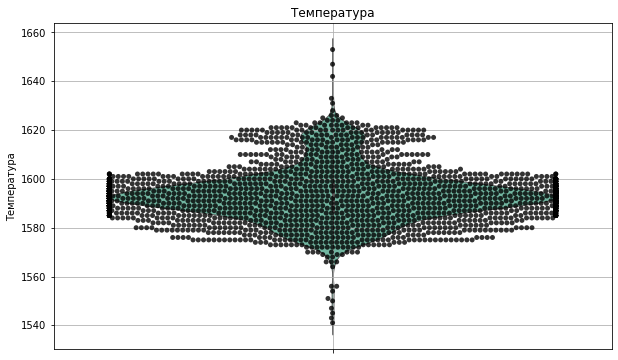

In [24]:
vio(df,'Температура')

In [25]:
df = df[(df['Температура'] < 1630) & (df['Температура'] >= 1560)]

53.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


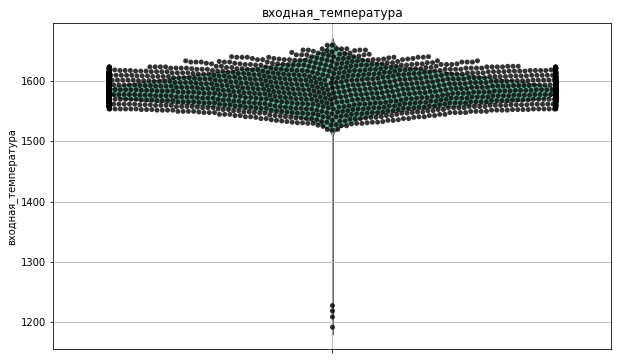

In [26]:
vio(df,'входная_температура')

In [27]:
df = df[(df['входная_температура'] < 1659) & (df['входная_температура'] > 1520)]

63.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


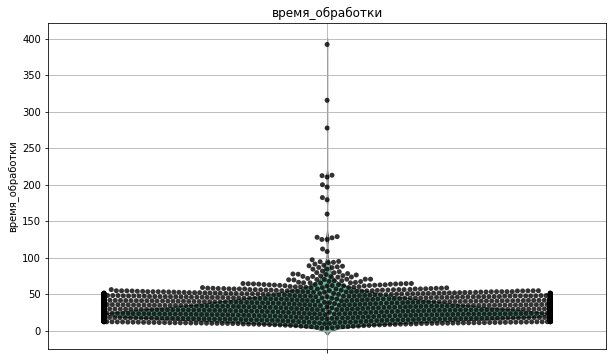

In [28]:
vio(df,'время_обработки')

In [29]:
df = df[(df['время_обработки'] < 100)]

9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


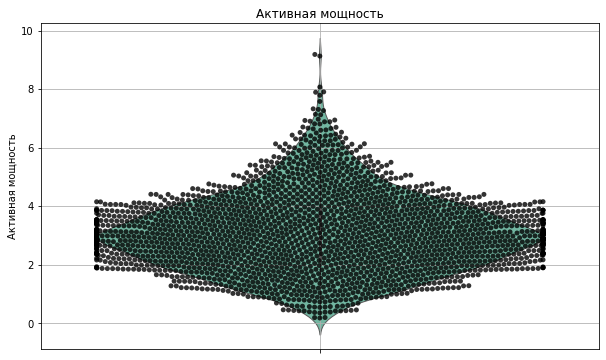

In [30]:
vio(df,'Активная мощность')

In [31]:
df = df[(df['Активная мощность'] < 7)]

6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


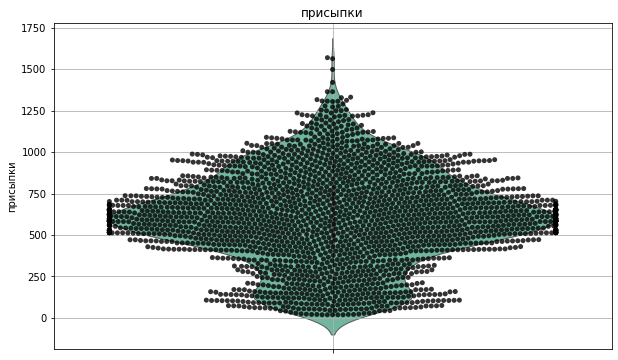

In [32]:
vio(df,'присыпки')

In [33]:
df = df[(df['присыпки'] < 1375)]

25.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


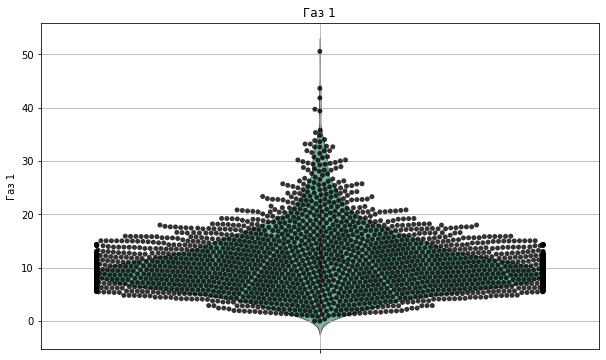

In [34]:
vio(df,'Газ 1')

In [35]:
df = df[(df['Газ 1'] < 37)]

30.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


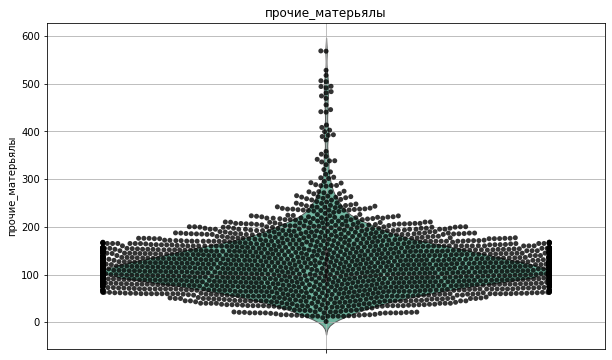

In [36]:
vio(df,'прочие_матерьялы')

In [37]:
df = df[(df['прочие_матерьялы'] < 300)]

In [38]:
df.describe()

,Температура,входная_температура,время_обработки,Активная мощность,присыпки,Газ 1,прочие_матерьялы
count,2189.000000,2189.000000,2189.000000,2189.000000,2189.000000,2189.000000,2189.000000
mean,1593.301964,1587.144358,29.713279,3.077015,605.433988,11.029031,119.283827
std,10.426363,23.027509,13.540967,1.270507,274.057914,5.676737,49.686124
min,1564.000000,1525.000000,3.900000,0.186226,19.000000,0.008399,1.918800
25%,1587.000000,1571.000000,20.000000,2.159281,443.000000,7.240750,87.287199
50%,1593.000000,1586.000000,26.683333,3.004564,609.000000,9.979713,115.053116
75%,1598.000000,1603.000000,37.350000,3.866013,788.000000,13.864435,149.210877
max,1628.000000,1654.000000,94.700000,6.973446,1364.000000,35.769306,295.364159


In [39]:
df

,Время замера,Температура,первый_замер,входная_температура,время_обработки,Активная мощность,присыпки,Газ 1,прочие_матерьялы
key,,,,,,,,,
1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0,14.350000,4.878147,553.0,29.749986,60.059998
2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0,21.750000,3.052598,582.0,12.555561,96.052315
3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0,21.666667,2.525882,544.0,28.554793,91.160157
4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0,6.466667,3.209250,595.0,18.841219,89.063515
5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0,12.700000,3.347173,584.0,5.413692,98.352796
...,...,...,...,...,...,...,...,...,...
2495,2019-08-06 00:54:42,1591.0,2019-08-06 00:35:45,1570.0,18.950000,3.210690,719.0,7.125735,89.150879
2496,2019-08-06 01:29:52,1591.0,2019-08-06 01:02:54,1554.0,26.966667,4.203064,796.0,9.412616,114.179527
2497,2019-08-06 01:53:50,1589.0,2019-08-06 01:41:53,1571.0,11.950000,2.212379,665.0,6.271699,103.134723


## Выводы по исследовательскому анализу
- Есть выбивающиеся значения в активной мощьности, присыпках и прочих матерьялах, но их стоит оставить, так как они свойственны долгим обработкам. Совсем-совсем выбросы мы удалили)

### Уточнения:
- Я не уверен на счет правильности своего решения по поводу исключения из выборки партий с обработкой больше часа. Хотя возможно лучше бы удалить выбросы и из колонок с мощьностью и присыпками, но не является ли читерством формирование таких подбных "уютных" выборок?

In [40]:
# газ тоже удалим, так он ухудшает качество модели
df = df.drop(['Время замера', 'первый_замер', 'Газ 1'], axis=1)

## Обучение моделей
- Обучим разные модели. Для каждой подберем различные гиперпараметры. Предполагаю планку по 
    - Для оценки качества моделей используем метрику MAE
    - Cлучайный лес
    - CatBoostRegressor
    - Модель из библиотеки LightGBM.
- Проанализируем скорость работы и качество моделей.

In [41]:
df_train_no, df_test = train_test_split(df, test_size=0.18, random_state=12345) # 20% данных для тестовой выборки
df_train, df_valid = train_test_split(df_train_no, test_size=0.10, random_state=12345) # 10% данных для валидационной выборки
features = df_train_no.drop(['Температура'], axis=1)
target = df_train_no['Температура']
features_train = df_train.drop(['Температура'], axis=1)
target_train = df_train['Температура']
features_valid = df_valid.drop(['Температура'], axis=1)
target_valid = df_valid['Температура']
features_test = df_test.drop(['Температура'], axis=1)
target_test = df_test['Температура']
features_all = df_train.drop(['Температура'], axis=1)
target_all = df_train['Температура']

### Случайный лес

In [42]:
best_model = None
best_result = 10000
best_depth = 0
for depth in range(1, 20):
    model = RandomForestRegressor(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train) # обучите модель на тренировочной выборке
    predictions_valid = model.predict(features_valid) # получите предсказания модели на валидационной выборке
    # считаем качество модели на валидационной выборке
    result = mean_absolute_error(target_valid, predictions_valid) 
    if result < best_result:
            best_model = model
            best_result = result
            best_depth = depth        
print("Качество наилучшей модели Дерева решений на валидационной выборке:", 
      best_result, "Максимальная глубина:", best_depth)

Качество наилучшей модели Дерева решений на валидационной выборке: 5.66330327962133 Максимальная глубина: 17


### CatBoostRegressor
Находим:
- оптимальное количество деревьве
- лучшую скорость обучения

In [43]:
model = CatBoostRegressor(loss_function="MAE", random_seed = 12345, learning_rate =0.01, iterations=7000)

model.fit(features_train, target_train,
         eval_set=(features_valid, target_valid),
          verbose=False, plot=True, 
)
print(f"Model is fitted: {str(model.is_fitted())}")
print(f"Model params: {model.get_params()}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Model is fitted: True
Model params: {'iterations': 7000, 'learning_rate': 0.01, 'loss_function': 'MAE', 'random_seed': 12345}


In [44]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Активная мощность,30.409290
1,входная_температура,28.555818
2,время_обработки,14.948878
3,прочие_матерьялы,13.240442
4,присыпки,12.845572


#### Первичные параметры CatBoostRegressor
Лучшая скорость обучения 0.01  
Оптимальное количество интераций 5668  
Валидационная MAE - 5.486  
Для улучшения качетва предсказвания мы уже удалили столбец с газом, давайте еще что нибудь настроить.

In [45]:
model = CatBoostRegressor(loss_function="MAE", random_seed = 12345, learning_rate =0.01, iterations=5000,
                              train_dir = "crossentropy", boosting_type='Plain',bootstrap_type='Bernoulli', subsample=0.5)

model.fit(features_train, target_train,
         eval_set=(features_valid, target_valid),
          verbose=False, plot=True, 
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

5.46! Качество улучшилось!

#### Лучшие параметры CatBoostRegressor
Лучшая скорость обучения 0.01  
Оптимальное количество интераций 3100  
Валидационная MAE - 5,461 
boosting_type='Plain',bootstrap_type='Bernoulli', subsample=0.5

Для сравнения приведу другие модели:

In [46]:
# общий класс для проведения исследований 
class Comparator:
    # переинициализация 
    def _reset(self):
        # перечень моделей и их гиперпараметров для перебора
        self.estimators = { 
            'LinearRegression': {
                'estimator': LinearRegression(),
                'grid': {
                    'fit_intercept': [True, False],
                    'normalize': [True, False]
                },
            },
            'RandomForestRegressor': {
                'estimator': RandomForestRegressor(),
                'grid': {
                    'n_estimators': [11, 29, 43],
                    'max_depth': [2, 3, 5],
                    'random_state': [GLOBAL_RANDOM_STATE]                
                },
            },
            'LGBMRegressor': {
                'estimator': LGBMRegressor(),
                'grid': {
                    'n_estimators': [90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 500, 1000, 2000, 4000, 5000],
                    'max_depth': [2, 3, 5],
                    'random_state': [GLOBAL_RANDOM_STATE]                
                }
            },   
            'CatBoostRegressor': {
                'estimator': CatBoostRegressor(),
                'grid': {
                    'verbose': [False],
                    'n_estimators': [5668],
                    'learning_rate': [0.01],
                    'random_state': [GLOBAL_RANDOM_STATE]                
                }
            },   
        }
        
    # расчет качества: единая точка, чтобы можно было легко изменить по ходу работы
    @staticmethod
    def _error(targ, targ_pred):
        error = mean_absolute_error(targ, targ_pred)
        return error

    # сравнение алгоритмов
    def process(self, 
                    ufeat_train: pd.DataFrame, utarg_train: pd.Series, 
                    ufeat_test: pd.DataFrame, utarg_test: pd.DataFrame,
                    feat_categorial: list,
                    feat_numeric: list,
                    activate: list = None) -> None:
        start_time = time.perf_counter()
        self._reset()
        feat_train = ufeat_train.copy().reset_index(drop=True)
        feat_test = ufeat_test.copy().reset_index(drop=True)
        targ_train = utarg_train.copy().reset_index(drop=True);
        targ_test = utarg_test.copy().reset_index(drop=True);   
        
        feat_train_scaled, feat_test_scaled = self._scale(feat_train, feat_test, feat_numeric)
        feat_train, feat_test = self._encoding(feat_train_scaled, feat_test_scaled, feat_categorial)

        self.feat_train = feat_train
        self.feat_test = feat_test
    
        for estimator_name in self.estimators:
            estimator = self.estimators[estimator_name]['estimator']
            if activate != None:
                if not estimator_name in activate:
                    continue
            self._gridsearch_wrapper(estimator,
                                     feat_train,
                                     targ_train,
                                     feat_categorial,
                                     feat_numeric)

            self._predict_and_score(estimator, feat_train, targ_train, 'pred_train', 'pred_score_train','pred_time_train')
            self._predict_and_score(estimator, feat_test, targ_test, 'pred_test', 'pred_score_test','pred_time_test') 
            
        end_time = time.perf_counter()
        print('Общее время:', (end_time-start_time))
        
        
    def _gridsearch_wrapper(self,
                            estimator,
                            feat_train: pd.DataFrame,
                            targ_train: pd.DataFrame,
                            feat_categorial: list,
                            feat_numeric: list):
        self._gridsearch(estimator, feat_train, targ_train)    
        
    # масштабирование
    def _scale(self, feat_train: pd.DataFrame, feat_valid: pd.DataFrame, feat_numeric: list) -> list:
        scaler = StandardScaler()
        scaler.fit(feat_train[feat_numeric])
        feat_train[feat_numeric] = scaler.transform(feat_train[feat_numeric])
        feat_valid[feat_numeric] = scaler.transform(feat_valid[feat_numeric])
        return [feat_train, feat_valid]        

    # ohe
    def _encoding(self, feat_train: pd.DataFrame, feat_valid: pd.DataFrame, feat_categorial: list) -> list:
        feat_train = pd.get_dummies(feat_train, drop_first=True, columns=feat_categorial)
        feat_valid = pd.get_dummies(feat_valid, drop_first=True, columns=feat_categorial)
        return [feat_train, feat_valid]        
    
    
    # предсказания с лучшими параметрами и расчет метрики 
    def _predict_and_score(self,
                           estimator,
                           feat: pd.DataFrame, 
                           targ: pd.Series, 
                           pred_key: str, 
                           score_key: str,
                           pred_time_key: str) -> None:
            estimator_name = estimator.__class__.__name__
            start_time = time.perf_counter()
            pred = self.estimators[estimator_name]['best'].predict(feat)
            end_time = time.perf_counter()
            self.estimators[estimator_name][pred_key] = pd.Series(pred)
            self.estimators[estimator_name][score_key] = Comparator._error(targ, pred)
            self.estimators[estimator_name][pred_time_key] = round(end_time-start_time, 3)
            
        
    # подбор гиперпараметров и сохранение лучшей модели для каждого конкретного алгоритма
    def _gridsearch(self, estimator: object, feat: pd.DataFrame, targ: pd.Series) -> None:
        start_time = time.perf_counter()
        estimator_name = estimator.__class__.__name__
        gscv = GridSearchCV(
                estimator,
                self.estimators[estimator_name]['grid'],
                scoring=make_scorer(Comparator._error, greater_is_better=False),
                cv=3,
                verbose=0,
                return_train_score=True,
                refit=True,
                n_jobs=4
        )
        gscv.fit(feat, targ)
        end_time = time.perf_counter()
        timedelta = round(end_time-start_time,3)
        self.estimators[estimator_name]['params'] = gscv.best_params_
        self.estimators[estimator_name]['score'] = gscv.best_score_ * (-1)
        self.estimators[estimator_name]['best'] = gscv.best_estimator_
        self.estimators[estimator_name]['time_fit'] = timedelta
        print('Выбор гиперпараметров', estimator_name,'занял',"{:.3f}".format(timedelta), 'секунд')
            
    # сводный отчет о результатах
    def report(self):
        frame = pd.DataFrame(
            { 
                "Estimator": [], 
                "Лучшие параметры": [], 
                "CV-MAE (train)": [],
                "MAE (train)": [],
                "MAE (test)": [],
                "Time (fit)": [],
                "Time (predict, train)": [],
                "Time (predict, test)": []
            })
        for estimator_name in self.estimators:
            if 'best' in self.estimators[estimator_name]:
                frame.loc[len(frame)] = [
                    estimator_name,
                    self.estimators[estimator_name]['params'], 
                    self.estimators[estimator_name]['score'], 
                    self.estimators[estimator_name]['pred_score_train'], 
                    self.estimators[estimator_name]['pred_score_test'], 
                    self.estimators[estimator_name]['time_fit'], 
                    self.estimators[estimator_name]['pred_time_train'], 
                    self.estimators[estimator_name]['pred_time_test']
                ]
        return frame
            
    def predictions(self, classname: str) -> list:
        for estimator in self.estimators:
            if estimator.__class__.__name__  == classname:
                result = {
                    'pred_train': self.estimators[estimator]['pred_train'], 
                    'pred_test': self.estimators[estimator]['pred_test'] 
                }
                return result
        return None
    
    # масштабированные feature_impotrances во всех best models
    def scaled_feature_importances(self, round_digits=3, sort_ascending=False) -> pd.DataFrame:
        scaled_feature_importances = pd.DataFrame(columns=self.feat_train.columns)
        for estimator_name in self.estimators:
            estimator = self.estimators[estimator_name]['best']
            if hasattr(estimator,'feature_importances_'):
                scaled_feature_importances.loc[estimator_name] = estimator.feature_importances_
        scaler = MinMaxScaler()
        transposed = scaled_feature_importances.transpose()
        transposed_scaled_feature_importances = pd.DataFrame(
                                                    scaler.fit_transform(transposed),
                                                    columns=transposed.columns, 
                                                    index=transposed.index)
        cols = list(transposed_scaled_feature_importances.columns.values)
        return transposed_scaled_feature_importances\
                .apply(lambda x: round(x, round_digits))\
                .sort_values(by=cols, ascending=sort_ascending)  

In [47]:
lists = features_train.columns.tolist()
cat = []
lists
GLOBAL_RANDOM_STATE = 12345
comp = Comparator()
comp.process(features_train, target_train, features_valid, target_valid,cat, lists)
x = comp.report()
x

Выбор гиперпараметров LinearRegression занял 4.031 секунд
Выбор гиперпараметров RandomForestRegressor занял 2.317 секунд
Выбор гиперпараметров LGBMRegressor занял 45.443 секунд
Выбор гиперпараметров CatBoostRegressor занял 36.993 секунд
Общее время: 88.96296742372215


,Estimator,Лучшие параметры,CV-MAE (train),MAE (train),MAE (test),Time (fit),"Time (predict, train)","Time (predict, test)"
0,LinearRegression,"{'fit_intercept': True, 'normalize': True}",5.884413,5.853095,5.793254,4.031,0.002,0.001
1,RandomForestRegressor,"{'max_depth': 5, 'n_estimators': 29, 'random_s...",6.179359,5.460298,6.360208,2.317,0.005,0.003
2,LGBMRegressor,"{'max_depth': 3, 'n_estimators': 120, 'random_...",5.772603,4.816507,5.706569,45.443,0.090,0.002
3,CatBoostRegressor,"{'learning_rate': 0.01, 'n_estimators': 5668, ...",5.846329,2.749212,5.606475,36.993,0.009,0.002


## Проверка модели на тестовой выборке

In [48]:
best_model = CatBoostRegressor(loss_function="MAE", random_seed = 12345, learning_rate =0.01, iterations=1563,  
                              boosting_type='Plain',bootstrap_type='Bernoulli', subsample=0.5)

best_model.fit(features_all, target_all,
          verbose=False
)
predict  = best_model.predict(features_test)
mean_absolute_error(target_test, predict)


5.385489077472371

### Выводы:
- Данная модель помогает достаточно точно(в среднем +- 5,38 градуса) предсказывать текущую температуру ковша изходя из данных по активной мощности, входной_температуре, времени_обработки, проволочных матерьялах и присыпках. Данные перечисленны в порядке важности для модели. Что позволит избежать излишнего перегревания и различных издержек по замере температур ковша, что положительно скажется на экономии электроэнергии и износе функциональных частей ковша и прочего обородования. 
- На основе данной модели можно выстроить энергоэффиктивные процессы нагревания, когда нагрев ковша будет происходить ровно столько времени, сколько необходимо для достижения необходимой температуры.
- Также если дополнить датафрейм данными о хим.составе газа, матерьялов, о бригадах, электродах и прочему, можно регистрировать аномалии, когда температура выходит за эти средние +-5,38 градуса и выявлять новые факторы, которые критично влияют на финальную температуру, а так же собирать статистику для выявления скрытых неполадок, уровню износа, а также по эффективности работы бригад.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА 2</u></b>
</font>
<font color='green'><br>
ОК, Андрей, однозначно хорошая работа!!!<br>
Я бы привёл ещё такие эпитеты: смелый, аналитический, вдумчивый проект.<br>
Обработка данных, модельная работа, важность факторов - многое удалось как надо<br> Очень здорово, что сразу ищешь новые фичи, думаешь над ними, анализируешь. Это тот самый подход, который нужен, чтобы искать ту саму модель для заказчика)<br><br>
<font color='red'><br>    
По твоему вопросу:<br>
1) Надо с целевой подразобраться - оставил комментарий в начале проекта. Там макс надо по времени, а не позначению - привёл доказательство)) Если это скорректириовать - всё получится.<br>
2) По cv: ниже оставлю суперфункцию (как-то досталась она мне по наследству)) Попробуй её раскрутить для себя. В любом случае - она может помочь тебе в дальнейшем.<br>
3) Факторы время - лучше НЕ ИСПОЛЬЗОВАТЬ в нашем проекте. У нас НЕ временной ряд. Поэтому бизнес-велью от этого факотора не будет.<br>
<font color='green'><br>    
БУДУ ждать корректировки)<br>
